## GATConv  - Parallel

In [209]:
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import MinMaxScaler
import sys
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from scipy.fftpack import fft, ifft
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

In [210]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [211]:
sys.path.append('/mnt/e/eVTOL_model/eVTOL-VehicleModel/src')


# Import necessary functions
from utility_functions import downsample_to_35
from utility_functions import organize_data

# Import all the models
from af_escnn_cl import ESCNN_Cl
from af_escnn_cd import ESCNN_Cd

from af_rbf_cl import RBFLayer_cl, RBFNet_cl
from af_rbf_cd import RBFLayer_cd, RBFNet_cd

### Initialize Airfoil Models

In [212]:
# Initialize airfoil models
root_airfoilModelsTrained = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/airfoil/'
# root_scalers = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/scalers/'

# Load the model weights
af_model_ESCNN_Cl = ESCNN_Cl()
af_model_ESCNN_Cl.load_state_dict(torch.load(root_airfoilModelsTrained + '2024-11-18_model_Cl_ESCNN_lr1e-05_e1500_rbf170_convL4.pth'))
af_model_ESCNN_Cl = af_model_ESCNN_Cl.to(device)
af_model_ESCNN_Cl.eval()

# Load the model weights
af_model_ESCNN_Cd = ESCNN_Cd()
af_model_ESCNN_Cd.load_state_dict(torch.load(root_airfoilModelsTrained + '2024-11-18_model_Cd_ESCNN_lr5e-05_e250_convL3.pth'))
af_model_ESCNN_Cd = af_model_ESCNN_Cd.to(device)
af_model_ESCNN_Cd.eval()

input_size = 140
output_size = 4
num_rbf_units = 4

kmeans_center_cl = torch.load(root_airfoilModelsTrained + '2024-11-19_airfoil_model_Cl_ESCNN_RBF_lr0.06_epoch200_rbfUnits4_RBFcenters.pth')
kmeans_center_cd = torch.load(root_airfoilModelsTrained + '2024-11-19_airfoil_model_Cd_ESCNN_RBF_lr0.025_epoch100_rbfUnits4_RBFcenters.pth')


class airfoilModel_cl(RBFNet_cl):
    def __init__(self):
        super(airfoilModel_cl, self).__init__(input_size, num_rbf_units, output_size, kmeans_center_cl)


class airfoilModel_cd(RBFNet_cd):
    def __init__(self):
        super(airfoilModel_cd, self).__init__(input_size, num_rbf_units, output_size, kmeans_center_cd)


# Initialize the model
airfoil_cl = airfoilModel_cl()
airfoil_cl.load_state_dict(torch.load(root_airfoilModelsTrained + '2024-11-19_airfoil_model_Cl_ESCNN_RBF_lr0.06_epoch200_rbfUnits4.pth'))

airfoil_cd = airfoilModel_cd()
airfoil_cd.load_state_dict(torch.load(root_airfoilModelsTrained + '2024-11-19_airfoil_model_Cd_ESCNN_RBF_lr0.025_epoch100_rbfUnits4.pth'))

airfoil_cl = airfoil_cl.to(device)
airfoil_cd = airfoil_cd.to(device)

airfoil_cl.eval()
airfoil_cd.eval()



/tmp/ipykernel_281577/829076333.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  af_model_ESCNN_Cl.load_state_dict(torch.load(root_airfoilModelsTrained + '2024-11-18_mode

airfoilModel_cd(
  (rbf): RBFLayer_cd()
  (fc): Linear(in_features=4, out_features=4, bias=True)
)

## Load Wing Data

In [213]:
from create_wing_dataset import WingDataset, subdir_condition_wing   # Make sure to reload the create wing dataset module manually after changes

# root_dir_wing = '/mnt/e/Course_Materials/ROM/wing_model/FLOWUnsteady_simulations/eMO_dataset_train'
root_dir_wing = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/FLOWUnsteady_simulations/aircraft_data/training_data'

# Canard dataset
dataset_canard = WingDataset(root_dir_wing, 
                                af_model_ESCNN_Cl=af_model_ESCNN_Cl, 
                                af_model_ESCNN_Cd=af_model_ESCNN_Cd,
                                airfoil_cl=airfoil_cl, 
                                airfoil_cd=airfoil_cd, 
                                device=device,
                                wing_name = 'Canard',     # select 'wing_main' or 'Canard'  
                                subdir_condition=subdir_condition_wing)

inputs_canard, outputs_canard = dataset_canard[0:]

input_tensor_canard = inputs_canard
input_tensor_canard = inputs_canard.squeeze(1)  # Reshaping
print("Input shape (Canard dataset):", input_tensor_canard.shape)

output_tensor_canard = outputs_canard.squeeze(1)
print("Output shape (Canard dataset):",output_tensor_canard.shape) 

# Wing dataset
dataset_wing = WingDataset(root_dir_wing, 
                            af_model_ESCNN_Cl=af_model_ESCNN_Cl, 
                            af_model_ESCNN_Cd=af_model_ESCNN_Cd,
                            airfoil_cl=airfoil_cl, 
                            airfoil_cd=airfoil_cd, 
                            device=device,
                            wing_name = 'wing_main',     # select 'wing_main' or 'Canard'  
                            subdir_condition=subdir_condition_wing)

inputs_wing, outputs_wing = dataset_wing[0:]

input_tensor_wing = inputs_wing
input_tensor_wing = inputs_wing.squeeze(1)  # Reshaping
print("Input shape (Wing dataset):", input_tensor_wing.shape)

output_tensor_wing = outputs_wing.squeeze(1)
print("Output shape (Wing dataset):",output_tensor_wing.shape) 




Input shape (Canard dataset): torch.Size([22, 277, 10])
Output shape (Canard dataset): torch.Size([22, 277, 2])
Input shape (Wing dataset): torch.Size([22, 277, 10])
Output shape (Wing dataset): torch.Size([22, 277, 2])


## Load Rotor Data

In [214]:
from create_rotor_dataset import PropellerDataset, subdir_condition_rotor

# Root directory where simulation subdirectories are stored
# root_dir_rotor = '/mnt/e/Course_Materials/ROM/rotor_solver/FLOWUnsteady_simulations/train_data'
root_dir_rotor = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/FLOWUnsteady_simulations/aircraft_data/training_data'

# dataset - Rotor L1
dataset_rotor_L1 = PropellerDataset(root_dir_rotor,
                           rotor_notation = 'L1',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                           subdir_condition=subdir_condition_rotor)
inputs_rL1, outputs_rL1 = dataset_rotor_L1[0:]


input_tensor_rL1 = inputs_rL1.squeeze(1)  # Reshaping
print("Input shape (rotor - L1):", input_tensor_rL1.shape) 

output_tensor_rL1 = outputs_rL1.squeeze(1)
print("Output shape (rotor - L1):",output_tensor_rL1.shape) 


# dataset - Rotor L2
dataset_rotor_L2 = PropellerDataset(root_dir_rotor,
                           rotor_notation = 'L2',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                           subdir_condition=subdir_condition_rotor)
inputs_rL2, outputs_rL2 = dataset_rotor_L2[0:]


input_tensor_rL2 = inputs_rL2.squeeze(1)  # Reshaping
print("Input shape (rotor - L2):", input_tensor_rL2.shape) 

output_tensor_rL2 = outputs_rL2.squeeze(1)
print("Output shape (rotor - L2):",output_tensor_rL2.shape) 

# dataset - Rotor L3
dataset_rotor_L3 = PropellerDataset(root_dir_rotor,
                           rotor_notation = 'L3',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                           subdir_condition=subdir_condition_rotor)
inputs_rL3, outputs_rL3 = dataset_rotor_L3[0:]


input_tensor_rL3 = inputs_rL3.squeeze(1)  # Reshaping
print("Input shape (rotor - L3):", input_tensor_rL3.shape) 

output_tensor_rL3 = outputs_rL3.squeeze(1)
print("Output shape (rotor - L3):",output_tensor_rL3.shape) 

# dataset - Rotor L4
dataset_rotor_L4 = PropellerDataset(root_dir_rotor,
                           rotor_notation = 'L4',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                           subdir_condition=subdir_condition_rotor)
inputs_rL4, outputs_rL4 = dataset_rotor_L4[0:]


input_tensor_rL4 = inputs_rL4.squeeze(1)  # Reshaping
print("Input shape (rotor - L4):", input_tensor_rL4.shape) 

output_tensor_rL4 = outputs_rL4.squeeze(1)
print("Output shape (rotor - L4):",output_tensor_rL4.shape) 

Input shape (rotor - L1): torch.Size([22, 280, 10])
Output shape (rotor - L1): torch.Size([22, 280, 4])
Input shape (rotor - L2): torch.Size([22, 280, 10])
Output shape (rotor - L2): torch.Size([22, 280, 4])
Input shape (rotor - L3): torch.Size([22, 280, 10])
Output shape (rotor - L3): torch.Size([22, 280, 4])
Input shape (rotor - L4): torch.Size([22, 280, 10])
Output shape (rotor - L4): torch.Size([22, 280, 4])


In [215]:
# dataset - Rotor R1
dataset_rotor_R1 = PropellerDataset(root_dir_rotor,
                           rotor_notation = 'R1',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                           subdir_condition=subdir_condition_rotor)
inputs_rR1, outputs_rR1 = dataset_rotor_R1[0:]


input_tensor_rR1 = inputs_rR1.squeeze(1)  # Reshaping
print("Input shape (rotor - R1):", input_tensor_rR1.shape) 

output_tensor_rR1 = outputs_rR1.squeeze(1)
print("Output shape (rotor - R1):",output_tensor_rR1.shape) 


# dataset - Rotor R2
dataset_rotor_R2 = PropellerDataset(root_dir_rotor,
                           rotor_notation = 'R2',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                           subdir_condition=subdir_condition_rotor)
inputs_rR2, outputs_rR2 = dataset_rotor_R2[0:]


input_tensor_rR2 = inputs_rR2.squeeze(1)  # Reshaping
print("Input shape (rotor - R2):", input_tensor_rR2.shape) 

output_tensor_rR2 = outputs_rR2.squeeze(1)
print("Output shape (rotor - R2):",output_tensor_rR2.shape) 

# dataset - Rotor R3
dataset_rotor_R3 = PropellerDataset(root_dir_rotor,
                           rotor_notation = 'R3',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                           subdir_condition=subdir_condition_rotor)
inputs_rR3, outputs_rR3 = dataset_rotor_R3[0:]


input_tensor_rR3 = inputs_rR3.squeeze(1)  # Reshaping
print("Input shape (rotor - R3):", input_tensor_rR3.shape) 

output_tensor_rR3 = outputs_rR3.squeeze(1)
print("Output shape (rotor - R3):",output_tensor_rR3.shape) 

# dataset - Rotor R4
dataset_rotor_R4 = PropellerDataset(root_dir_rotor,
                           rotor_notation = 'R4',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                           subdir_condition=subdir_condition_rotor)
inputs_rR4, outputs_rR4 = dataset_rotor_R4[0:]


input_tensor_rR4 = inputs_rR4.squeeze(1)  # Reshaping
print("Input shape (rotor - R4):", input_tensor_rR4.shape) 

output_tensor_rR4 = outputs_rR4.squeeze(1)
print("Output shape (rotor - R4):",output_tensor_rR4.shape) 

Input shape (rotor - R1): torch.Size([22, 280, 10])
Output shape (rotor - R1): torch.Size([22, 280, 4])
Input shape (rotor - R2): torch.Size([22, 280, 10])
Output shape (rotor - R2): torch.Size([22, 280, 4])
Input shape (rotor - R3): torch.Size([22, 280, 10])
Output shape (rotor - R3): torch.Size([22, 280, 4])
Input shape (rotor - R4): torch.Size([22, 280, 10])
Output shape (rotor - R4): torch.Size([22, 280, 4])


## Load Wing Model and Initialize

In [216]:
from wing_static import LSTMNet_static

# Static Model
input_size_wing_stat = 10           # Number of input features
hidden_size_wing_stat = 50          # Hidden LSTM cells
output_size_wing_stat = 2           # Number of output features
num_layers_wing_stat = 3            # Number of LSTM layers

class WingModel_static(LSTMNet_static):
    def __init__(self):
        super(WingModel_static, self).__init__(input_size_wing_stat, hidden_size_wing_stat, output_size_wing_stat, num_layers_wing_stat)

# Initialize the model

root_wingModelsTrained = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/wing/'
root_wingScalersTrained = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/scalers/wing/'

wing_model_static = WingModel_static()
wing_model_static.load_state_dict(torch.load(root_wingModelsTrained+'2024-11-19_LSTM_eMO_wingModel_static_lr0.002_e1200_nL3_numNN50.pth'))
wing_model_static = wing_model_static.to(device)
wing_model_static.eval()

# Load the scaler
input_scaler_wing_stat = joblib.load(root_wingScalersTrained+'2024-11-19_LSTM_eMO_wingModel_static_ipScaler_lr0.002_e1200_nL3_numNN50.pkl')
output_scaler_wing_stat = joblib.load(root_wingScalersTrained+'2024-11-19_LSTM_eMO_wingModel_static_opScaler_lr0.002_e1200_nL3_numNN50.pkl')

/tmp/ipykernel_281577/1761514772.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wing_model_static.load_state_dict(torch.load(root_wingModelsTrained+'2024-11-19_LSTM_eM

## Load Rotor Model and Initialize

In [217]:
from rotor_model import LSTMNet_rotor

input_size = 10
hidden_size = 50
output_size = 4
num_layers = 2

class PropModel(LSTMNet_rotor):
    def __init__(self):
        super(PropModel, self).__init__(input_size, hidden_size, output_size, num_layers)

root_rotorModelsTrained = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/rotor/'
root_rotorScalersTrained = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/scalers/rotor/'

# Initialize the model
prop_model = PropModel()
prop_model.load_state_dict(torch.load(root_rotorModelsTrained+'2024-10-04_propModel_lr0.005_e1500_nL2_numNN50.pth'))
prop_model = prop_model.to(device)
prop_model.eval()

# Load the scaler
input_scaler_rotor = joblib.load(root_rotorScalersTrained+'2024-10-04_ipScaler_lr0.005_e1500_nL2_numNN50.pkl')
output_scaler_rotor = joblib.load(root_rotorScalersTrained+'2024-10-04_opScaler_lr0.005_e1500_nL2_numNN50.pkl')

/tmp/ipykernel_281577/3413111085.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  prop_model.load_state_dict(torch.load(root_rotorModelsTrained+'2024-10-04_propModel_lr0

In [218]:
from scipy.interpolate import interp1d
import numpy as np

def align_timesteps(data, target_length):
    original_length = data.shape[1]
    x = np.linspace(0, 1, original_length)
    x_new = np.linspace(0, 1, target_length)
    interpolator = interp1d(x, data, axis=1, kind='linear')
    return interpolator(x_new)


In [219]:
# class AircraftDataset(Dataset):
#     def __init__(self, wing_dataset, propeller_1_dataset, propeller_2_dataset, additional_data=None):
#         """
#         Args:
#             wing_dataset (WingDataset): Instance of WingDataset.
#             propeller_dataset (PropellerDataset): Instance of PropellerDataset.
#             additional_data (dict, optional): Any additional data to include in the dataset.
#         """
#         self.wing_dataset = wing_dataset
#         self.propeller_dataset_L1 = propeller_1_dataset
#         self.propeller_dataset_R1 = propeller_2_dataset
#         self.additional_data = additional_data or {}

#         # Combine data from wing and propeller datasets
#         self.data = []
#         self.targets = []

#         self._combine_data()

#     def _combine_data(self):
#         """
#         Combine input and target data from WingDataset and PropellerDataset.
#         """
#         inputs_wing, target_wing = self.wing_dataset[0:]
#         inputs_wing = inputs_wing.squeeze(1)
#         target_wing = target_wing.squeeze(1)

#         inputs_rotor_L1, target_rotor_L1 = self.propeller_dataset_L1[0:]
#         inputs_rotor_L1 = inputs_rotor_L1.squeeze(1)
#         target_rotor_L1 = target_rotor_L1.squeeze(1)

#         inputs_rotor_R1, target_rotor_R1 = self.propeller_dataset_R1[0:]
#         inputs_rotor_R1 = inputs_rotor_R1.squeeze(1)
#         target_rotor_R1 = target_rotor_R1.squeeze(1)

#         k = 0.1301                          # Scale factor
        
#         # Aircraft features - Constant
#         or1_x = 0.36 * k                    # distance between rotor 1 and the origin
#         or1_y = 3.842 * k
#         or1_z = 0.5 * k

#         # or2_x = 2.28 * k                    # distance between rotor 2 and the origin
#         # or2_y = 3.842 * k
#         # or2_z = 0.5 * k 
        
#         # or3_x = 4.20 * k                    # distance between rotor 3 and the origin
#         # or3_y = 3.842 * k
#         # or3_z = 0.5 * k 
        
#         # or4_x = 6.54 * k                    # distance between rotor 4 and the origin
#         # or4_y = 3.842 * k
#         # or4_z = 0.5 * k 

#         # r1r2_x = or2_x - or1_x              # distance between rotors 1 and 2
#         # r2r3_x = or3_x - or2_x              # distance between rotors 2 and 3
#         # r3r4_x = or4_x - or3_x              # distance between rotors 3 and 4
        
#         oc_x = 1.14 * k                     # distance between canard and the origin
#         oc_y = 0.0
#         oc_z = 0.35 * k
        
#         # ow_x = 4.505 * k                    # distance between wing and the origin
#         # ow_y = 0.0
#         # ow_z = -0.2 * k
        
#         # cw_x = ow_x - oc_x                  # distance between canard and wing 

#         cr1_x = oc_x - or1_x
#         cr1_y = oc_y - or1_y
#         cr1_z = oc_z - or1_z


#         # Aircraft features - time varying
#         # wing features
#         T = inputs_wing[:,:,0]
#         AOA = inputs_wing[:,:,1]    # Same for both rotors and wing
#         v_inf = inputs_wing[:,:,2]
#         # rotor features
#         omega = inputs_rotor_L1[:,:,2]  # Assumption: All rotors have same rotational velocity
#         omega = align_timesteps(omega, T.shape[1])
#         omega = torch.tensor(omega, dtype=torch.float32)
        
#         ref_angle_L1 = inputs_rotor_L1[:,:,1]
#         ref_angle_L1 = align_timesteps(ref_angle_L1, T.shape[1])
#         ref_angle_L1 = torch.tensor(ref_angle_L1, dtype=torch.float32)

#         ref_angle_R1 = inputs_rotor_R1[:,:,1]
#         ref_angle_R1 = align_timesteps(ref_angle_R1, T.shape[1])
#         ref_angle_R1 = torch.tensor(ref_angle_R1, dtype=torch.float32)
        
#         aircraft_input = torch.stack([T, AOA, v_inf, omega, ref_angle_L1, ref_angle_R1], dim=2)
#         print("Inputs shape (Aircraft)", aircraft_input.shape)


#         # Aircraft level targets
#         target_rotor_L1 = align_timesteps(target_rotor_L1, T.shape[1])
#         target_rotor_L1 = torch.tensor(target_rotor_L1, dtype=torch.float32)

#         target_rotor_R1 = align_timesteps(target_rotor_R1, T.shape[1])
#         target_rotor_R1 = torch.tensor(target_rotor_R1, dtype=torch.float32)

#         aircraft_target = torch.cat([target_wing, target_rotor_L1, target_rotor_R1], dim=2)
#         print("Targets shape (Aircraft)", aircraft_target.shape)


#     def __len__(self):
#         """
#         Returns the total number of sequences in the dataset.
#         """
#         return len(self.data)




In [220]:
class AircraftDataset(Dataset):
    def __init__(self, wing_dataset, propeller_1_dataset, propeller_2_dataset,
                 wing_ip_scaler, rotor_ip_scaler, wing_op_scaler, rotor_op_scaler,
                  additional_data=None):
        super().__init__()
        self.wing_dataset = wing_dataset
        self.propeller_dataset_L1 = propeller_1_dataset
        self.propeller_dataset_R1 = propeller_2_dataset
        self.additional_data = additional_data or {}
        self.wing_ip_scaler = wing_ip_scaler
        self.wing_op_scaler = wing_op_scaler
        self.rotor_ip_scaler = rotor_ip_scaler
        self.rotor_op_scaler = rotor_op_scaler

        # Constants
        k = 0.1301
        self.constants = {
            "or1_x": 0.36 * k,
            "or1_y": 3.842 * k,
            "or1_z": 0.5 * k,
            "oc_x": 1.14 * k,
            "oc_y": 0.0,
            "oc_z": 0.35 * k,
            "cr1_x": 1.14 * k - 0.36 * k,
            "cr1_y": 0.0 - 3.842 * k,
            "cr1_z": 0.35 * k - 0.5 * k,
        }

        # Initialize data storage
        self.data = {
            "time_varying_inputs": None,
            "constant_inputs": None,
            "node_data": {},  # Store node-specific time-varying data
        }
        self.targets = None

        # Combine datasets
        self._combine_data()

    def _combine_data(self):
        # Load wing and rotor datasets
        inputs_wing, target_wing = self.wing_dataset[0:]
        inputs_wing = inputs_wing.squeeze(1)
        target_wing = target_wing.squeeze(1)
        
        inputs_rotor_L1, target_rotor_L1 = self.propeller_dataset_L1[0:]
        inputs_rotor_L1 = inputs_rotor_L1.squeeze(1)
        target_rotor_L1 = target_rotor_L1.squeeze(1)

        inputs_rotor_R1, target_rotor_R1 = self.propeller_dataset_R1[0:]
        inputs_rotor_R1 = inputs_rotor_R1.squeeze(1)
        
        target_rotor_R1 = target_rotor_R1.squeeze(1)

        # Normalize the wing inputs
        inputs_wing_reshaped = inputs_wing.reshape(-1, 10)
        inputs_wing_normalized = self.wing_ip_scaler.transform(inputs_wing_reshaped.reshape(-1, 10)).reshape(inputs_wing.shape)
        inputs_wing_normalized = torch.tensor(inputs_wing_normalized, dtype=torch.float32)

        # Time-varying features
        T = inputs_wing_normalized[:, :, 0]
        AOA = inputs_wing_normalized[:, :, 1]
        v_inf = inputs_wing_normalized[:, :, 2]


        # Resize the rotor inputs
        inputs_resized_rotor_L1 = torch.tensor(align_timesteps(inputs_rotor_L1, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_R1 = torch.tensor(align_timesteps(inputs_rotor_R1, T.shape[1]), dtype=torch.float32)
        
        # Normalize the rotor inputs
        inputs_rotor_L1_reshaped = inputs_resized_rotor_L1.reshape(-1, 10)
        inputs_rotor_L1_normalized = self.rotor_ip_scaler.transform(inputs_rotor_L1_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_L1.shape)
        inputs_rotor_L1_normalized = torch.tensor(inputs_rotor_L1_normalized, dtype=torch.float32)

        inputs_rotor_R1_reshaped = inputs_resized_rotor_R1.reshape(-1, 10)
        inputs_rotor_R1_normalized = self.rotor_ip_scaler.transform(inputs_rotor_R1_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_R1.shape)
        inputs_rotor_R1_normalized = torch.tensor(inputs_rotor_R1_normalized, dtype=torch.float32)

        
        # omega = torch.tensor(align_timesteps(inputs_rotor_L1[:, :, 2], T.shape[1]), dtype=torch.float64)
        # ref_angle_L1 = torch.tensor(align_timesteps(inputs_rotor_L1[:, :, 1], T.shape[1]), dtype=torch.float32)
        # ref_angle_R1 = torch.tensor(align_timesteps(inputs_rotor_R1[:, :, 1], T.shape[1]), dtype=torch.float32)
        omega = inputs_rotor_L1_normalized[:, :, 2]
        sine_component = inputs_rotor_L1_normalized[:, :, 3]
        cos_component = inputs_rotor_L1_normalized[:, :, 4]
        ref_angle_L1 = inputs_rotor_L1_normalized[:, :, 1]
        ref_angle_R1 = inputs_rotor_R1_normalized[:, :, 1]

        # Store time-varying inputs in self.data
        self.data["time_varying_inputs"] = torch.stack([T, AOA, v_inf, omega, ref_angle_L1, ref_angle_R1], dim=2)       # [22, 277, 6]
        self.data["node_data"]["wing"] = inputs_wing_normalized                    # [22, 277, 10]
        self.data["node_data"]["rotor_1"] = inputs_rotor_L1_normalized     # [22, 277, 10]
        self.data["node_data"]["rotor_2"] = inputs_rotor_R1_normalized     # [22, 277, 10]

        # Store constant features
        self.data["constant_inputs"] = torch.tensor(list(self.constants.values()), dtype=torch.float32)

        # Combine targets
        target_rotor_L1 = torch.tensor(align_timesteps(target_rotor_L1, T.shape[1]), dtype=torch.float32)       # [22, 277, 4]
        target_rotor_R1 = torch.tensor(align_timesteps(target_rotor_R1, T.shape[1]), dtype=torch.float32)       # [22, 277, 4]

        target_wing_reshaped = target_wing.reshape(-1, 2)
        target_wing_normalized = self.wing_op_scaler.transform(target_wing_reshaped.reshape(-1, 2)).reshape(target_wing.shape)
        target_wing_normalized = torch.tensor(target_wing_normalized, dtype=torch.float32)

        target_rotor_L1_reshaped = target_rotor_L1.reshape(-1, 4)
        target_rotor_L1_normalized = self.rotor_op_scaler.transform(target_rotor_L1_reshaped.reshape(-1, 4)).reshape(target_rotor_L1.shape)
        target_rotor_L1_normalized = torch.tensor(target_rotor_L1_normalized, dtype=torch.float32)

        target_rotor_R1_reshaped = target_rotor_R1.reshape(-1, 4)
        target_rotor_R1_normalized = self.rotor_op_scaler.transform(target_rotor_R1_reshaped.reshape(-1, 4)).reshape(target_rotor_R1.shape)
        target_rotor_R1_normalized = torch.tensor(target_rotor_R1_normalized, dtype=torch.float32)

        self.targets = torch.cat([target_wing_normalized, target_rotor_L1_normalized, target_rotor_R1_normalized], dim=2)

    def __len__(self):
        return len(self.data["time_varying_inputs"])

    def __getitem__(self, idx):
        inputs = {
            "node_data": {
                "rotor_1": self.data["node_data"]["rotor_1"][idx],
                "rotor_2": self.data["node_data"]["rotor_2"][idx],
                "wing": self.data["node_data"]["wing"][idx]
            },
            "constant_inputs": self.data["constant_inputs"],
            "time_varying_inputs": self.data["time_varying_inputs"][idx]
        }
        targets = self.targets[idx]
        return inputs, targets


In [221]:
from torch_geometric.data import Data

def create_graph(inputs, targets):
    """
    Create a graph structure from dataset inputs and targets.

    Args:
        inputs (dict): Includes node data and constant inputs.
        targets (Tensor): The target outputs.

    Returns:
        Data: PyTorch Geometric Data object representing the graph.
    """
    # print("Inputs in create_graph:", inputs)
    # print("Node Data:", inputs.get("node_data", "Missing 'node_data'"))
    # Extract node features
    node_features = torch.stack([
        inputs["node_data"]["wing"],            # Node 0: Wing features
        inputs["node_data"]["rotor_1"],         # Node 1: Rotor 1 features
        inputs["node_data"]["rotor_2"]          # Node 2: Rotor 2 features
        
    ], dim=0)  # Shape: (num_nodes, timesteps, features)

    source = [0, 1, 0, 2]
    target = [1, 0, 2, 0]
    
    # Define edge index (connectivity)
    edge_index = torch.tensor([source, target], dtype=torch.long)


    cr1_x = inputs["constant_inputs"][6]
    cr1_y = inputs["constant_inputs"][7]
    cr1_z = inputs["constant_inputs"][8]

    edge_attr = torch.tensor([[cr1_x, cr1_y, cr1_z]] * len(source), dtype=torch.float32)  # Same for all edges

    global_inputs = torch.stack([inputs["time_varying_inputs"]])
    global_targets = torch.stack([targets])


    # Create graph data object
    graph = Data(
        x=node_features,                # Node features
        edge_index=edge_index,          # Edge connectivity
        edge_attr=edge_attr,            # Edge features
        global_input = global_inputs,   # Aircraft-level inputs
        y=global_targets                       # Targets
    )
    return graph


In [222]:
# def create_graph_batch(inputs_batch, targets_batch):
#     graphs = []
#     for input, target in zip(inputs_batch, targets_batch):
#         print("Inputs-iter:", type(input))
#         print("Targets-iter:", type(target))

#         print("Inputs-provided:", type(inputs_batch))
#         print("Targets-provided:", type(targets_batch))
        
#         # Ensure each input is processed correctly
#     #     if not isinstance(inputs, dict):
#     #         raise ValueError(f"Expected inputs to be a dict, got {type(inputs)}")
#     #     graph = create_graph(inputs, targets)  # Create graph for each input/target pair
#     #     graphs.append(graph)
    # return graphs

In [223]:
from torch_geometric.loader import DataLoader

class GraphDataset(Dataset):
    def __init__(self, dataset):
        """
        Initialize the dataset with a list of inputs and targets.
        
        Args:
            dataset (list): A list of dictionaries, each containing 'inputs' and 'targets'.
        """
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        inputs, targets = self.dataset[idx]
        graph = create_graph(inputs, targets)
        return graph

In [224]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_graph(graph):
    """
    Visualize a PyTorch Geometric graph using NetworkX.
    
    Args:
        graph (torch_geometric.data.Data): The graph to visualize.
    """
    # Convert PyTorch Geometric Data object to NetworkX graph
    nx_graph = to_networkx(graph, edge_attrs=["edge_attr"], to_undirected=True)

    # Plot the graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(nx_graph)  # Use spring layout for positioning
    nx.draw(
        nx_graph,
        pos,
        with_labels=True,
        node_color="skyblue",
        node_size=500,
        edge_color="gray",
        font_weight="bold"
    )

    # Annotate edge attributes
    edge_labels = nx.get_edge_attributes(nx_graph, "edge_attr")
    edge_labels = {k: tuple(round(x, 2) for x in v) for k, v in edge_labels.items()}  # Round for readability
    nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels, font_size=10)

    plt.title("Graph Structure")
    plt.show()


In [225]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv

class CompositeGNN(nn.Module):
    def __init__(self, pretrained_wing, pretrained_rotor1, pretrained_rotor2, 
                 global_input_dim, edge_input_dim, hidden_dim, output_dim, heads=2):
        super(CompositeGNN, self).__init__()

        #
        self.hidden_dim = hidden_dim
        self.global_input_dim = global_input_dim
        self.output_dim = output_dim
        
        # Pre-trained models for the nodes
        self.pretrained_wing = pretrained_wing
        self.pretrained_rotor1 = pretrained_rotor1
        self.pretrained_rotor2 = pretrained_rotor2

        # Linear layers to ensure all node outputs match hidden_dim
        self.wing_transform = nn.Linear(2, hidden_dim)  # Transform wing output
        self.rotor1_transform = nn.Linear(4, hidden_dim)  # Transform rotor 1 output
        self.rotor2_transform = nn.Linear(4, hidden_dim)  # Transform rotor 2 output
        self.global_inputs_transform = nn.Linear(global_input_dim, hidden_dim)


        # GNN layers
        # self.conv1 = GCNConv(hidden_dim + global_input_dim, hidden_dim)
        # self.conv2 = GCNConv(hidden_dim, hidden_dim)

        self.gat1 = GATConv(hidden_dim + global_input_dim, hidden_dim, heads=heads, concat=True)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=2, concat=False)

        # Fully connected layer for output
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, node_inputs, edge_index, edge_attr, global_inputs, batch_size, num_nodes):
        """
        Forward pass of the Composite GNN.
        """
        # Process node-specific inputs through pre-trained models
        # node_embeddings = []
        
        # Create masks to extract node inputs by type
        wing_indices = torch.arange(0, batch_size) * num_nodes  # Select nodes 0 and 3
        rotor1_indices = torch.arange(0, batch_size) * num_nodes + 1  # Select nodes 1 and 4
        rotor2_indices = torch.arange(0, batch_size) * num_nodes + 2  # Select nodes 2 and 5

        node_embeddings_wing = self.wing_transform(self.pretrained_wing(node_inputs[wing_indices]))  # Wing
        node_embeddings_rotor1 = self.rotor1_transform(self.pretrained_rotor1(node_inputs[rotor1_indices]))  # Rotor 1
        node_embeddings_rotor2 = self.rotor2_transform(self.pretrained_rotor2(node_inputs[rotor2_indices]))  # Rotor 2

        
        x_cat = torch.cat([node_embeddings_wing, node_embeddings_rotor1, node_embeddings_rotor2], dim=0)
        

        # x = x.view(3, 2, 277, self.hidden_dim)  # Shape: [nodes, batches, timesteps, features]

        # global_inputs_expanded = global_inputs.unsqueeze(0).repeat(x.shape[0], 1, 1, 1)
        global_inputs_expanded = torch.cat([global_inputs, global_inputs, global_inputs], dim=0)

        # print("X Shape:", x.shape)
        # print("Global Inputs Shape:", global_inputs_expanded.shape)

        # Concatenate global inputs to each node's embeddings
        # global_inputs_repeated = global_inputs.repeat(x.shape[0], 1)  # Broadcast global inputs
        x = torch.cat([x_cat, global_inputs_expanded], dim=-1)  # Concatenate along feature dimension
        x = x.reshape(-1, self.hidden_dim+self.global_input_dim)

        # print("X Shape:", x.shape)

        # Ensure x and edge_index have the correct dtypes
        x = x.float()  # Convert x to torch.float32
        edge_index = edge_index.long()  # Ensure edge_index is torch.long

        # Pass through GNN layers
        # x = self.conv1(x, edge_index)
        # x = torch.relu(x)
        # x = self.conv2(x, edge_index)
        # x = torch.relu(x)

        x = self.gat1(x, edge_index)
        x = torch.relu(x)
        x = self.gat2(x, edge_index)
        x = torch.relu(x)

        # Fully connected layer for output
        out = self.fc(x)

        out = out.reshape(batch_size*num_nodes, -1, self.output_dim)

        reshaped_outputs = out.view(batch_size, num_nodes, 277, self.output_dim)

        
        graph_outputs = reshaped_outputs.mean(dim=1)

        return graph_outputs



In [226]:
# Instantiate the dataset
dataset_aircraft = AircraftDataset(dataset_canard,
                        dataset_rotor_L1,
                        dataset_rotor_R1,
                        input_scaler_wing_stat,
                        input_scaler_rotor,
                        output_scaler_wing_stat,
                        output_scaler_rotor)

# # Example: Create a graph for a specific sample
# inputs, targets = dataset_aircraft[0]

# print(inputs["time_varying_inputs"].shape)


In [227]:
# from torch.utils.data import DataLoader

# dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# graphs = []
# for batch_inputs, batch_targets in dataloader:
#     for inputs, targets in zip(batch_inputs, batch_targets):
#         graph = create_graph(inputs, targets)
#         graphs.append(graph)

# inputs, targets = dataset[2]
# graph = create_graph(inputs, targets)
# visualize_graph(graph)
# print(graph)

In [228]:
# Constants
EPOCHS = 800
BATCH_SIZE = 2
LEARNING_RATE = 7e-4

In [229]:
graph_dataset = GraphDataset(dataset_aircraft)


pretrained_wing = wing_model_static
pretrained_rotor1 = prop_model
pretrained_rotor2 = prop_model

# Ensure all parameters are trainable (for fine-tuning)
for param in pretrained_wing.parameters():
    param.requires_grad = True

for param in pretrained_rotor1.parameters():
    param.requires_grad = True

for param in pretrained_rotor2.parameters():
    param.requires_grad = True

In [230]:
from torch.utils.data import random_split
# Define the split ratio
train_ratio = 0.65
val_ratio = 0.35

# Calculate split sizes
dataset_size = len(graph_dataset)
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

# Perform the split
train_dataset_aircraft, val_dataset_aircraft = random_split(graph_dataset, [train_size, val_size])

print("Train Dataset Size:", len(train_dataset_aircraft))
print("Validation Dataset Size:", len(val_dataset_aircraft))

train_dataloader = DataLoader(train_dataset_aircraft, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset_aircraft, batch_size=BATCH_SIZE, shuffle=True)


Train Dataset Size: 14
Validation Dataset Size: 8


In [231]:
hidden_dim = 100
global_input_dim = dataset_aircraft.data["time_varying_inputs"].shape[-1]
edge_input_dim = dataset_aircraft.data["constant_inputs"][6:].shape[-1]
output_dim = dataset_aircraft.targets.shape[-1]

composite_model = CompositeGNN(pretrained_wing, pretrained_rotor1, pretrained_rotor2,
                                global_input_dim, edge_input_dim, hidden_dim, output_dim).to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(composite_model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()



In [232]:
train_losses = []
eval_losses = []

print("[INFO] training the network...")

# Training loop
for epoch in range(EPOCHS):
    composite_model.train()
    running_loss = 0.0
    
    for graph_batch in train_dataloader:
        # inputs_batch, targets_batch, graph_batch = batch
                
        node_inputs = (graph_batch.x).to(device)
        edge_index = graph_batch.edge_index
        edge_attr = graph_batch.edge_attr
        global_inputs = graph_batch.global_input
        targets = (graph_batch.y).to(device)
        # global_inputs = inputs_batch["time_varying_inputs"]

        node_inputs = node_inputs.to(device)
        edge_index = edge_index.to(device)
        edge_attr = edge_attr.to(device)
        global_inputs = global_inputs.to(device)

        # print(node_inputs)
        # print("Tar:", targets.shape)

        # Forward pass
        optimizer.zero_grad()
        outputs = composite_model(node_inputs, edge_index, edge_attr, global_inputs, BATCH_SIZE, num_nodes = 3)
        # print("Outputs:", outputs.shape)
        
        # break
        # print("Outputs:", outputs.shape)
        # print("Targets:", targets_batch.shape)
        
        # Compute loss
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    avg_train_loss = running_loss/len(train_dataloader)
    train_losses.append(avg_train_loss)

    # break
    # Evaluation loop
    composite_model.eval()
    eval_loss = 0.0

    for graph_batch in val_dataloader:
        # inputs_batch, targets_batch, graph_batch = batch
        
        
        node_inputs = (graph_batch.x).to(device)
        edge_index = graph_batch.edge_index
        edge_attr = graph_batch.edge_attr
        global_inputs = graph_batch.global_input
        targets = (graph_batch.y).to(device)
        # global_inputs = inputs_batch["time_varying_inputs"]

        node_inputs = node_inputs.to(device)
        edge_index = edge_index.to(device)
        edge_attr = edge_attr.to(device)
        global_inputs = global_inputs.to(device)

        # Forward pass

        outputs = composite_model(node_inputs, edge_index, edge_attr, global_inputs, BATCH_SIZE, num_nodes = 3)   

        # Compute loss
        loss = criterion(outputs, targets)

        eval_loss += loss.item()

    avg_eval_loss = eval_loss / len(val_dataloader)
    eval_losses.append(avg_eval_loss)


    
    print(f'Epoch [{epoch+1}/{EPOCHS}],\n Training Loss: {running_loss/len(train_dataloader):.8f}')
    print(f'Evaluation Loss: {eval_loss/len(val_dataloader):.4f}')

    

print("[INFO] Finished training the network...")

[INFO] training the network...
Epoch [1/800],
 Training Loss: 0.14327130
Evaluation Loss: 0.0674
Epoch [2/800],
 Training Loss: 0.06643682
Evaluation Loss: 0.0276
Epoch [3/800],
 Training Loss: 0.04214537
Evaluation Loss: 0.0311
Epoch [4/800],
 Training Loss: 0.03601088
Evaluation Loss: 0.0244
Epoch [5/800],
 Training Loss: 0.03462037
Evaluation Loss: 0.0250
Epoch [6/800],
 Training Loss: 0.03377519
Evaluation Loss: 0.0219
Epoch [7/800],
 Training Loss: 0.03284903
Evaluation Loss: 0.0225
Epoch [8/800],
 Training Loss: 0.03498392
Evaluation Loss: 0.0236
Epoch [9/800],
 Training Loss: 0.03250646
Evaluation Loss: 0.0228
Epoch [10/800],
 Training Loss: 0.03209943
Evaluation Loss: 0.0234
Epoch [11/800],
 Training Loss: 0.03120160
Evaluation Loss: 0.0237
Epoch [12/800],
 Training Loss: 0.03102518
Evaluation Loss: 0.0217
Epoch [13/800],
 Training Loss: 0.03285663
Evaluation Loss: 0.0213
Epoch [14/800],
 Training Loss: 0.03018742
Evaluation Loss: 0.0230
Epoch [15/800],
 Training Loss: 0.031382

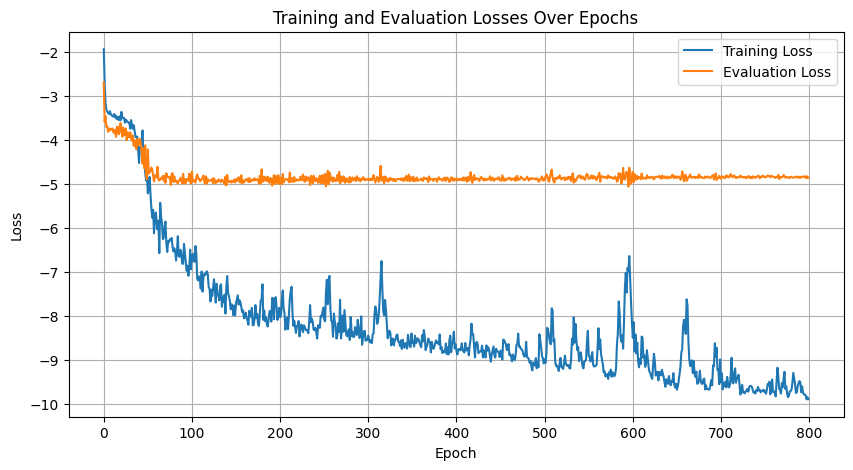

In [233]:
# Plotting the training and evaluation losses
plt.figure(figsize=(10, 5))
plt.plot(np.log(train_losses), label='Training Loss')
plt.plot(np.log(eval_losses), label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## Test the model

/mnt/e/eVTOL_model/eVTOL-VehicleModel/vehicle_env/lib/python3.11/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/mnt/e/eVTOL_model/eVTOL-VehicleModel/vehicle_env/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/mnt/e/eVTOL_model/eVTOL-VehicleModel/vehicle_env/lib/python3.11/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/mnt/e/eVTOL_model/eVTOL-VehicleModel/vehicle_env/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/mnt/e/eVTOL_model/eVTOL-VehicleModel/vehicle_env/lib/python3.11/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the

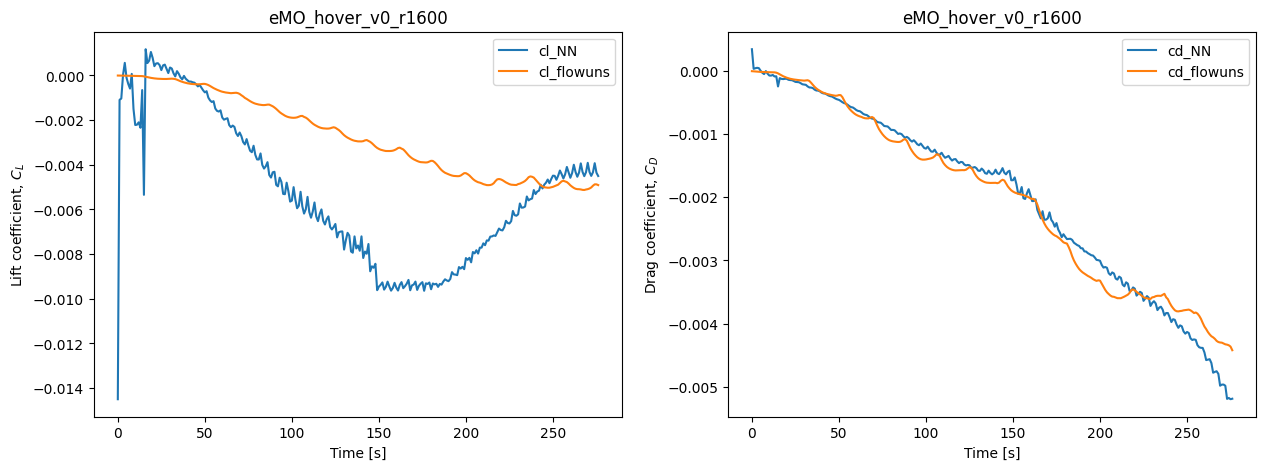

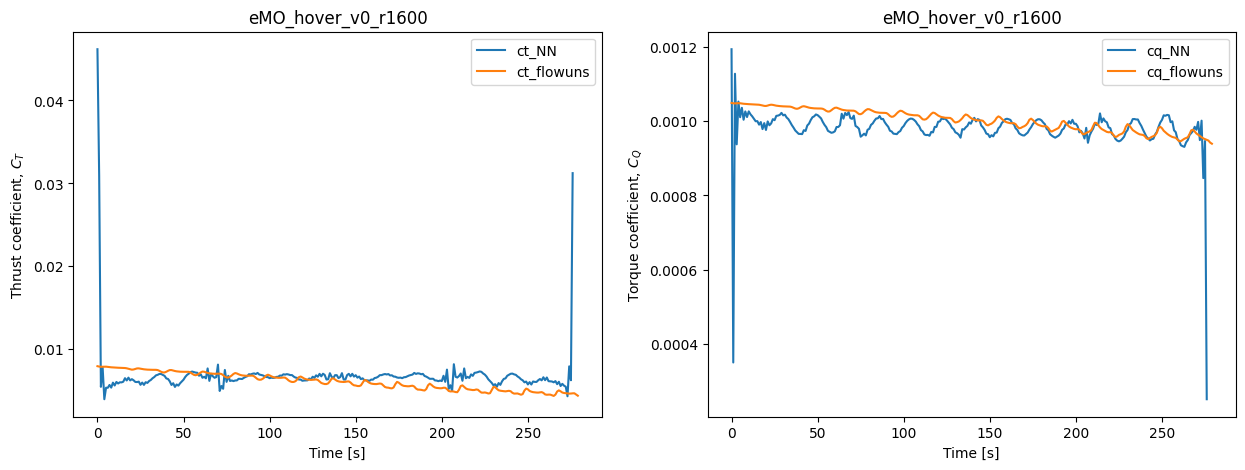

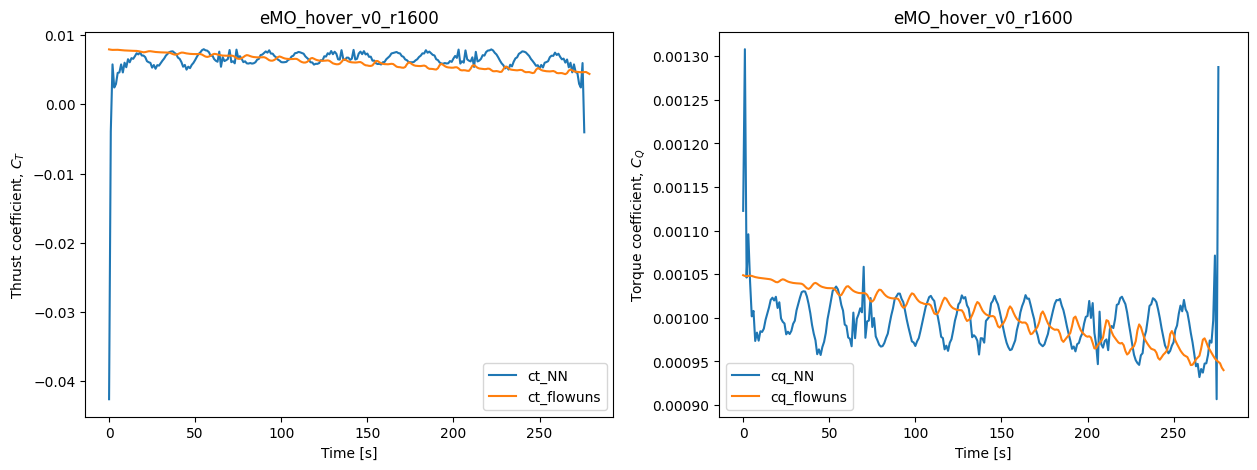

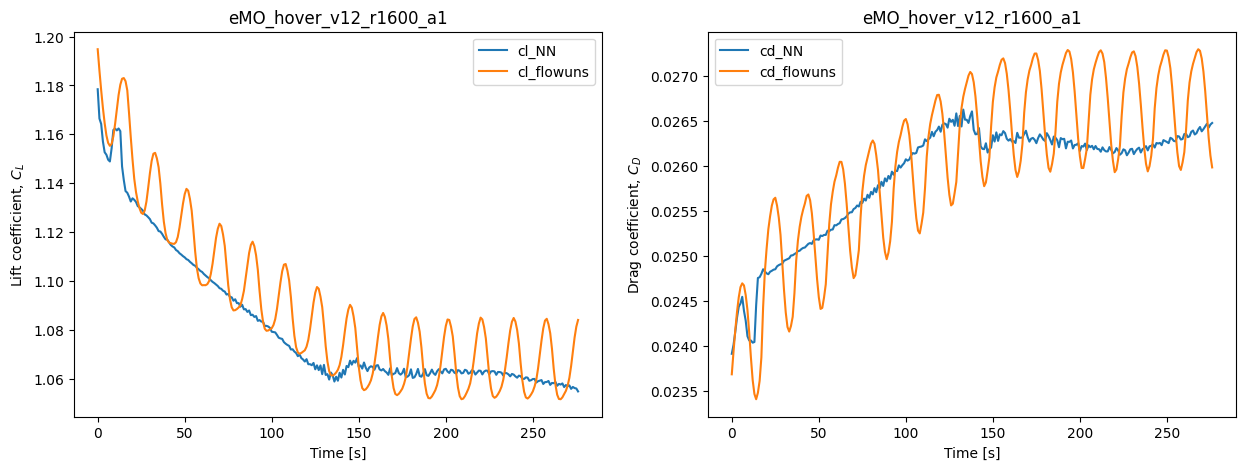

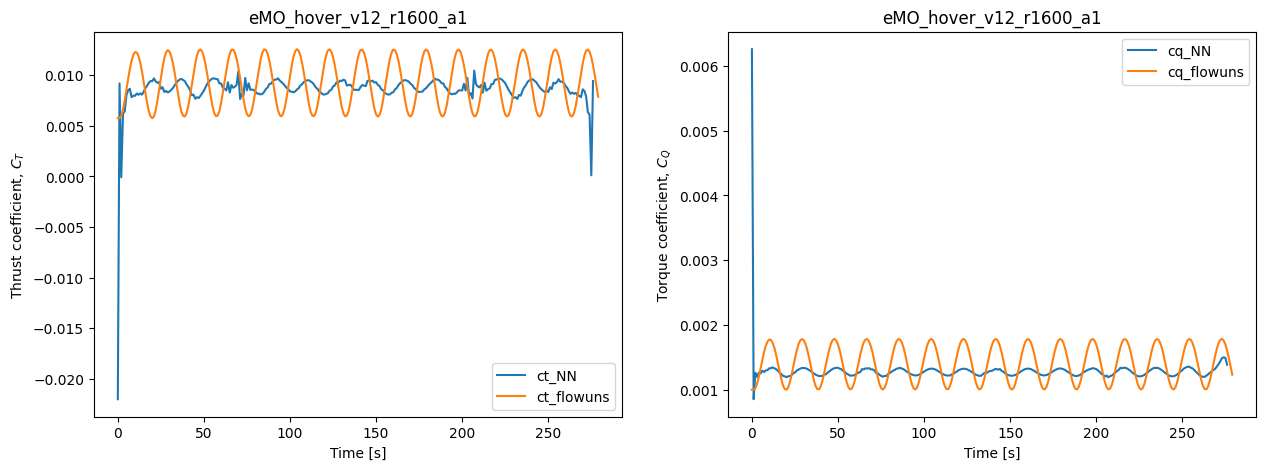

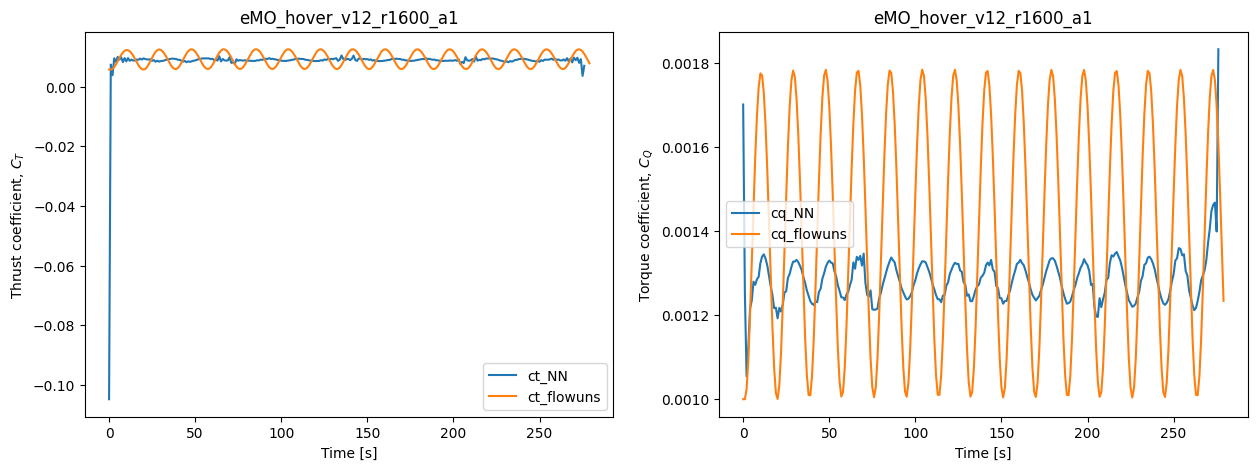

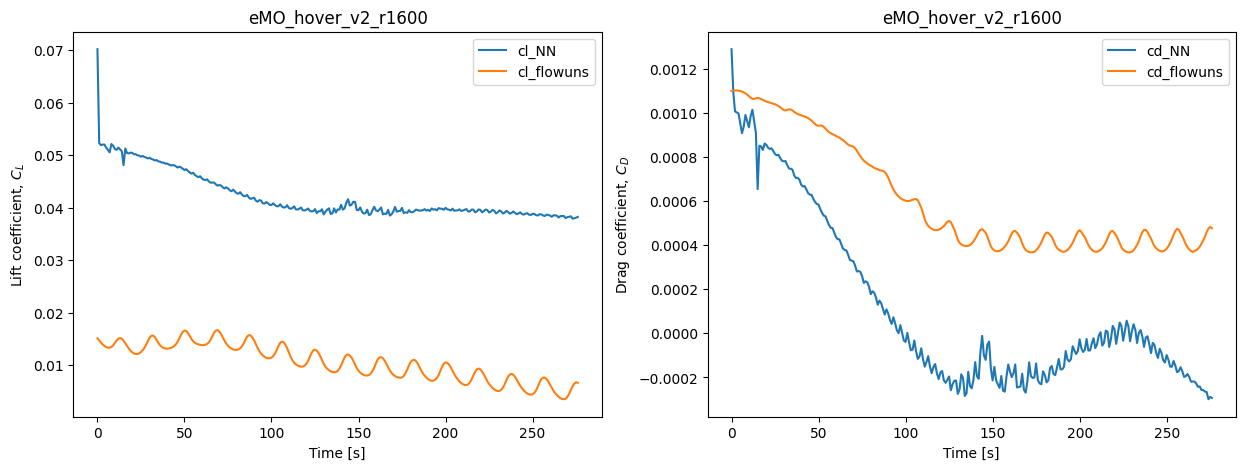

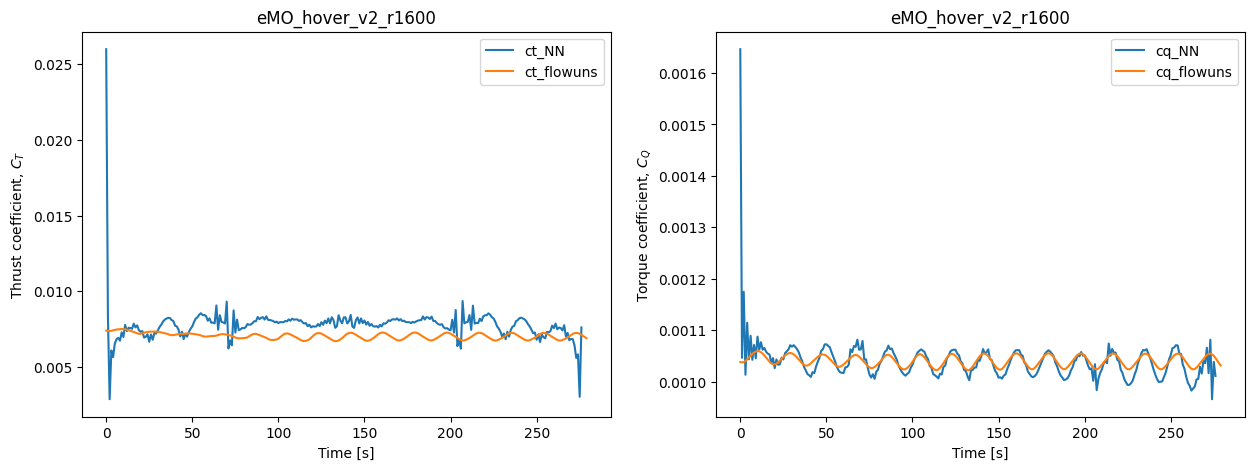

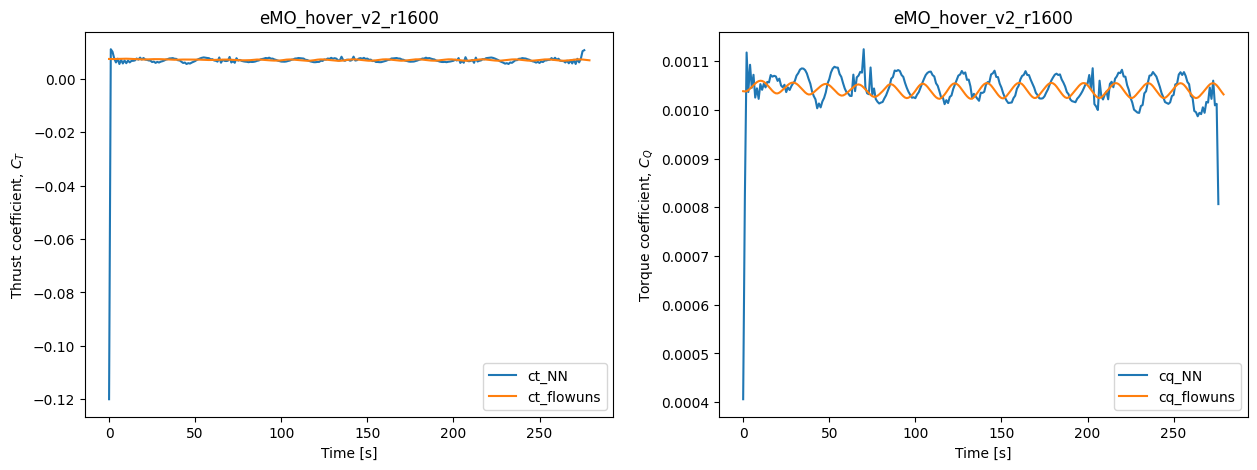

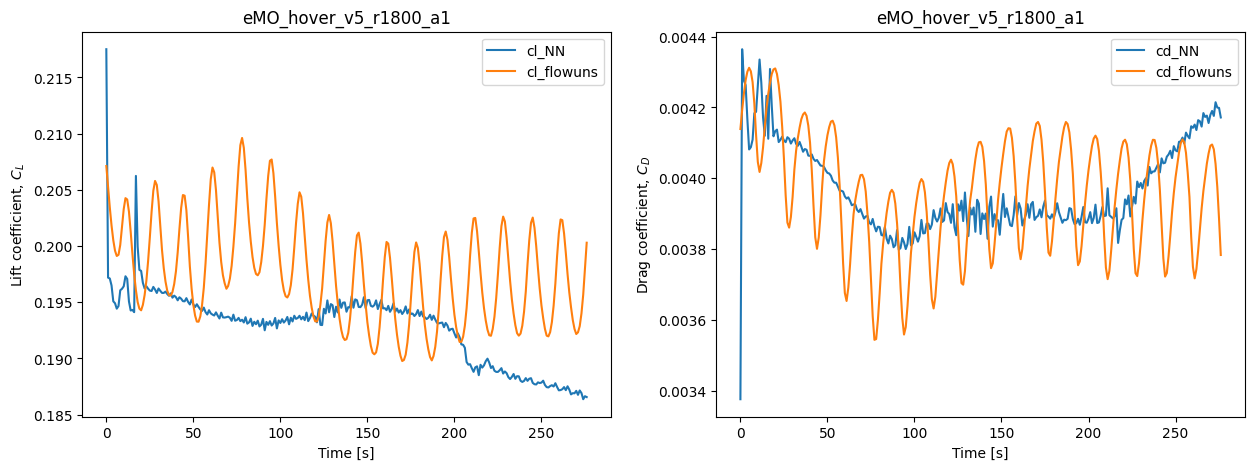

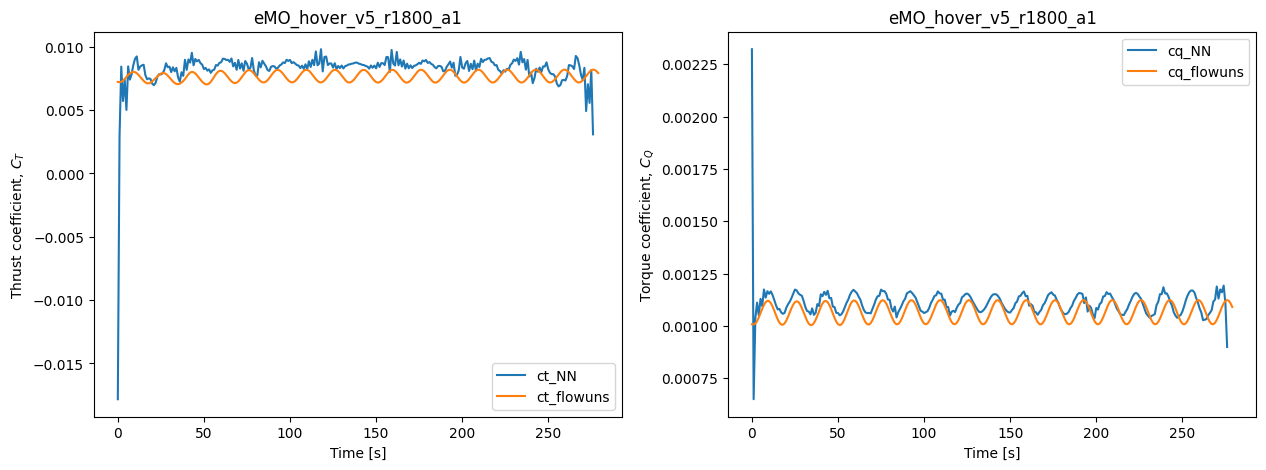

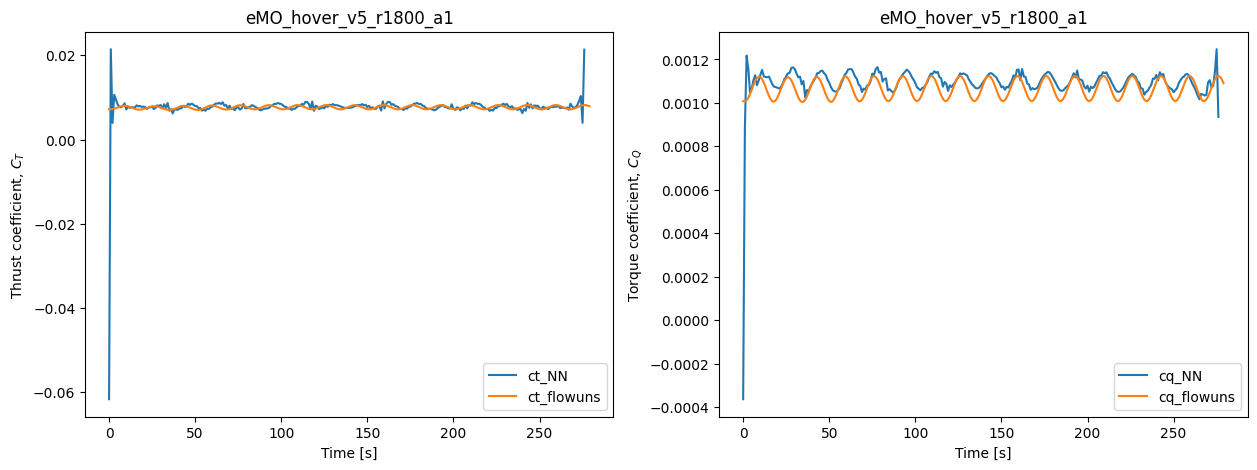

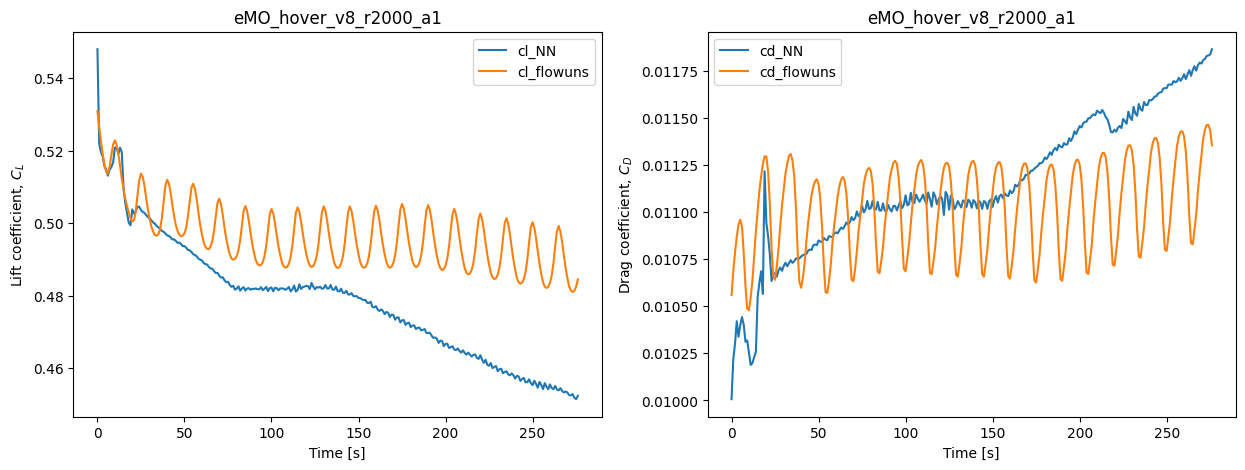

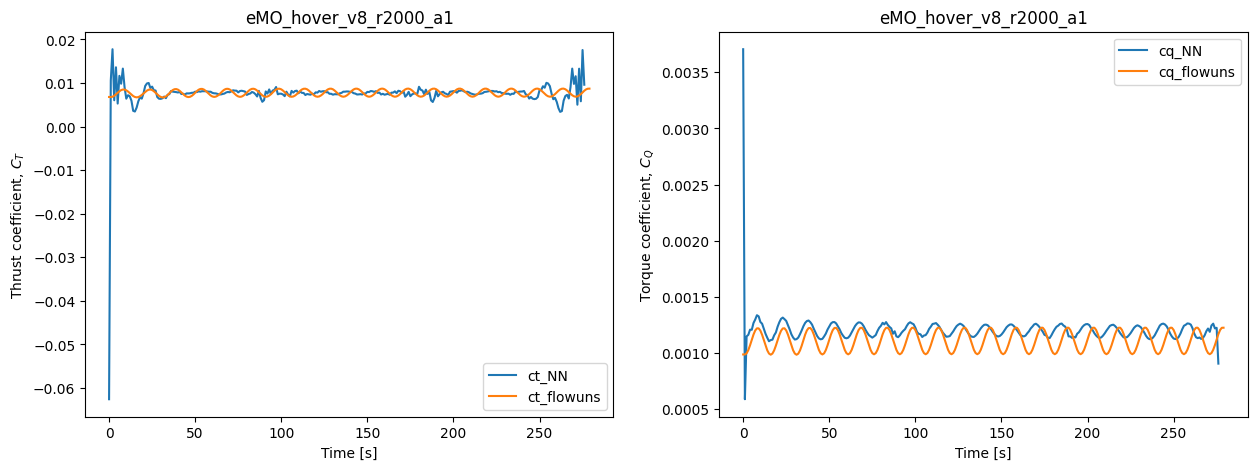

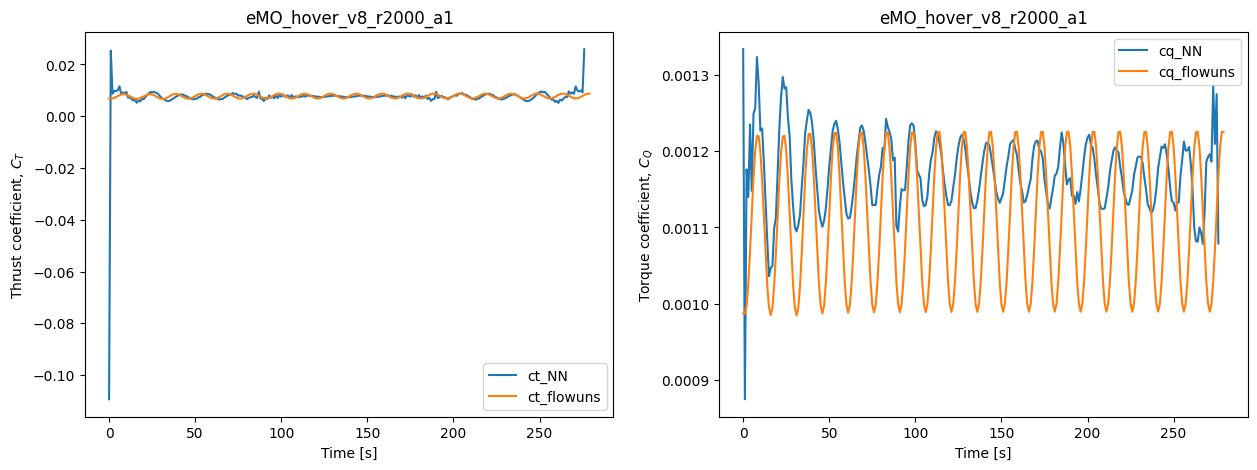

: 

In [234]:
root_test_base = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/FLOWUnsteady_simulations/aircraft_data/testing_data/'
batch_size_test = 1

for simulation_case in os.listdir(root_test_base):

    root_test_dir = root_test_base+simulation_case

    # Canard dataset
    dataset_canard_test = WingDataset(root_test_dir, 
                                    af_model_ESCNN_Cl=af_model_ESCNN_Cl, 
                                    af_model_ESCNN_Cd=af_model_ESCNN_Cd,
                                    airfoil_cl=airfoil_cl, 
                                    airfoil_cd=airfoil_cd, 
                                    device=device,
                                    wing_name = 'Canard',     # select 'wing_main' or 'Canard'  
                                    subdir_condition=subdir_condition_wing)

    inputs_canard_test, outputs_canard_test = dataset_canard_test[0:]

    input_tensor_canard_test = inputs_canard_test
    input_tensor_canard_test = inputs_canard_test.squeeze(1)  # Reshaping
    # print("Input shape (Canard dataset):", input_tensor_canard.shape)
    output_tensor_canard_test = outputs_canard_test.squeeze(1)
    # print("Output shape (Canard dataset):",output_tensor_canard.shape) 


    # dataset - Rotor L1
    dataset_rotor_L1_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'L1',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rL1_test, outputs_rL1_test = dataset_rotor_L1_test[0:]

    input_tensor_rL1_test = inputs_rL1_test.squeeze(1)  # Reshaping
    # print("Input shape (rotor - L1):", input_tensor_rL1.shape) 
    output_tensor_rL1_test = outputs_rL1_test.squeeze(1)
    # print("Output shape (rotor - L1):",output_tensor_rL1.shape)


    # dataset - Rotor R1
    dataset_rotor_R1_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'R1',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rR1_test, outputs_rR1_test = dataset_rotor_R1_test[0:]

    input_tensor_rR1_test = inputs_rR1_test.squeeze(1)  # Reshaping
    # print("Input shape (rotor - R1):", input_tensor_rR1.shape) 
    output_tensor_rR1_test = outputs_rR1_test.squeeze(1)
    # print("Output shape (rotor - R1):",output_tensor_rR1.shape) 

    dataset_aircraft_test = AircraftDataset(dataset_canard_test,
                                            dataset_rotor_L1_test,
                                            dataset_rotor_R1_test,
                                            input_scaler_wing_stat,
                                            input_scaler_rotor,
                                            output_scaler_wing_stat,
                                            output_scaler_rotor)

    # combined_dataset_test = GraphDataset(dataset_aircraft_test)

    # inputs_test, targets_test, graph_test = combined_dataset_test[0]

    # targets_test = targets_test.to(device)

    # node_inputs_test = (graph_test.x).to(device)
    # edge_index_test = (graph_test.edge_index).to(device)
    # edge_attr_test = (graph_test.edge_attr).to(device)
    # global_inputs_test = (inputs_test["time_varying_inputs"]).to(device)
    # global_inputs_test = global_inputs_test.unsqueeze(0)

    graph_dataset_test = GraphDataset(dataset_aircraft_test)

    graph_dataset_test = graph_dataset_test[0]

    node_inputs_test = (graph_dataset_test.x).to(device)
    edge_index_test = (graph_dataset_test.edge_index).to(device)
    edge_attr_test = (graph_dataset_test.edge_attr).to(device)
    global_inputs_test = (graph_dataset_test.global_input).to(device)
    targets_test = (graph_dataset_test.y).to(device)
    

    composite_model.eval()  # Set the model to evaluation mode


    with torch.no_grad():
        outputs_predicted = composite_model(node_inputs_test, edge_index_test,
                                             edge_attr_test, global_inputs_test,
                                             batch_size_test, num_nodes=3)

    
    
    outputs_predicted = outputs_predicted.cpu().detach().numpy()  # Convert tensor to numpy array
    outputs_predicted = outputs_predicted.squeeze(0)

    predicted_outputs_wing = outputs_predicted[:, 0:2]
    predicted_outputs_rotor_L1 = outputs_predicted[:, 2:6]
    predicted_outputs_rotor_R1 = outputs_predicted[:, 6:]
    
    predicted_outputs_wing_og_scl = output_scaler_wing_stat.inverse_transform(predicted_outputs_wing)
    predicted_outputs_rotor_L1_og_scl = output_scaler_rotor.inverse_transform(predicted_outputs_rotor_L1)
    predicted_outputs_rotor_R1_og_scl = output_scaler_rotor.inverse_transform(predicted_outputs_rotor_R1)


    time_steps = (global_inputs_test.squeeze(0))[:,0]

    cl_wing_NN = predicted_outputs_wing_og_scl[:, 0]
    cd_wing_NN = predicted_outputs_wing_og_scl[:, 1]

    fft_ct_nn_real_L1 = predicted_outputs_rotor_L1_og_scl[:, 0]
    fft_cq_nn_real_L1 = predicted_outputs_rotor_L1_og_scl[:, 2]
    
    fft_ct_nn_imag_L1 = predicted_outputs_rotor_L1_og_scl[:, 2]
    fft_cq_nn_imag_L1 = predicted_outputs_rotor_L1_og_scl[:, 3]

    complex_ct_nn_L1 = fft_ct_nn_real_L1 +1j * fft_ct_nn_imag_L1
    ct_test_NN_L1 = ifft(complex_ct_nn_L1)

    complex_cq_nn_L1 = fft_cq_nn_real_L1 +1j * fft_cq_nn_imag_L1
    cq_test_NN_L1 = ifft(complex_cq_nn_L1)


    fft_ct_nn_real_R1 = predicted_outputs_rotor_R1_og_scl[:, 0]
    fft_cq_nn_real_R1 = predicted_outputs_rotor_R1_og_scl[:, 2]
    
    fft_ct_nn_imag_R1 = predicted_outputs_rotor_R1_og_scl[:, 2]
    fft_cq_nn_imag_R1 = predicted_outputs_rotor_R1_og_scl[:, 3]

    complex_ct_nn_R1 = fft_ct_nn_real_R1 +1j * fft_ct_nn_imag_R1
    ct_test_NN_R1 = ifft(complex_ct_nn_R1)

    complex_cq_nn_R1 = fft_cq_nn_real_R1 +1j * fft_cq_nn_imag_R1
    cq_test_NN_R1 = ifft(complex_cq_nn_R1)

    

    cl_test_flowuns_wing = dataset_canard_test.get_variable('CL')
    cd_test_flowuns_wing = dataset_canard_test.get_variable('CD')
    ct_test_flowuns_L1 = dataset_rotor_L1_test.get_variable('CT')
    cq_test_flowuns_L1 = dataset_rotor_L1_test.get_variable('CQ')
    ct_test_flowuns_R1 = dataset_rotor_R1_test.get_variable('CT')
    cq_test_flowuns_R1 = dataset_rotor_R1_test.get_variable('CQ')


    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(cl_wing_NN, label = 'cl_NN')
    plt.plot((cl_test_flowuns_wing[0]), label = 'cl_flowuns')
    plt.xlabel('Time [s]')
    plt.ylabel('Lift coefficient, $C_L$')
    plt.title(simulation_case)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(cd_wing_NN, label = 'cd_NN')
    plt.plot(cd_test_flowuns_wing[0], label = 'cd_flowuns')
    plt.xlabel('Time [s]')
    plt.ylabel('Drag coefficient, $C_D$')
    plt.title(simulation_case)
    plt.legend()


    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(ct_test_NN_L1, label = 'ct_NN')
    plt.plot((ct_test_flowuns_L1[0]), label = 'ct_flowuns')
    plt.xlabel('Time [s]')
    plt.ylabel('Thrust coefficient, $C_T$')
    plt.title(simulation_case)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(cq_test_NN_L1, label = 'cq_NN')
    plt.plot(cq_test_flowuns_L1[0], label = 'cq_flowuns')
    plt.xlabel('Time [s]')
    plt.ylabel('Torque coefficient, $C_Q$')
    plt.title(simulation_case)
    plt.legend()

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(ct_test_NN_R1, label = 'ct_NN')
    plt.plot((ct_test_flowuns_R1[0]), label = 'ct_flowuns')
    plt.xlabel('Time [s]')
    plt.ylabel('Thrust coefficient, $C_T$')
    plt.title(simulation_case)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(cq_test_NN_R1, label = 'cq_NN')
    plt.plot(cq_test_flowuns_R1[0], label = 'cq_flowuns')
    plt.xlabel('Time [s]')
    plt.ylabel('Torque coefficient, $C_Q$')
    plt.title(simulation_case)
    plt.legend()





    